[Index](Index.ipynb) - [Back](Widget List.ipynb) - [Next](Widget Events.ipynb)

# Output widgets: leveraging Jupyter's display system

In [1]:
import ipywidgets as widgets

The `Output` widget can capture and display stdout, stderr and [rich output generated by IPython](http://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#module-IPython.display). You can also append output directly to an output widget, or clear it programmatically.

In [2]:
out = widgets.Output(layout={'border': '1px solid black'})
out

Output(layout=Layout(border='1px solid black'))

After the widget is created, direct output to it using a context manager. You can print text to the output area:

In [3]:
with out:
    for i in range(10):
        print(i, 'Hello world!')

0 Hello world!
1 Hello world!
2 Hello world!
3 Hello world!
4 Hello world!
5 Hello world!
6 Hello world!
7 Hello world!
8 Hello world!
9 Hello world!


Rich output can also be directed to the output area. Anything which displays nicely in a Jupyter notebook will also display well in the `Output` widget.

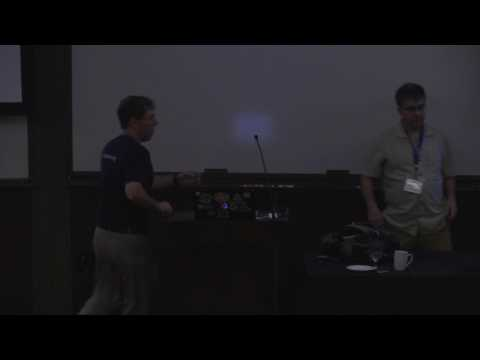

In [4]:
from IPython.display import YouTubeVideo
with out:
    display(YouTubeVideo('eWzY2nGfkXk'))

We can even display complex mimetypes, such as nested widgets, in an output widget.

In [5]:
with out:
    display(widgets.IntSlider())

IntSlider(value=0)

We can also append outputs to the output widget directly with the convenience methods `append_stdout`, `append_stderr`, or `append_display_data`.

In [6]:
out = widgets.Output(layout={'border': '1px solid black'})
out.append_stdout('Output appended with append_stdout')
out.append_display_data(YouTubeVideo('eWzY2nGfkXk'))
out

Output(layout=Layout(border='1px solid black'), outputs=({'output_type': 'stream', 'name': 'stdout', 'text': '…

We can clear the output by either using `IPython.display.clear_output` within the context manager, or we can call the widget's `clear_output` method directly.

In [7]:
out.clear_output()

`clear_output` supports the keyword argument `wait`. With this set to `True`, the widget contents are not cleared immediately. Instead, they are cleared the next time the widget receives something to display. This can be useful when replacing content in the output widget: it allows for smoother transitions by avoiding a jarring resize of the widget following the call to `clear_output`.

Finally, we can use an output widget to capture all the output produced by a function using the `capture` decorator.

In [8]:
@out.capture()
def function_with_captured_output():
    print('This goes into the output widget')
    raise Exception('As does this')
    
function_with_captured_output()

This goes into the output widget


Exception: As does this

`out.capture` supports the keyword argument `clear_output`. Setting this to `True` will clear the output widget every time the function is invoked, so that you only see the output of the last invocation. With `clear_output` set to `True`, you can also pass a `wait=True` argument to only clear the output once new output is available. Of course, you can also manually clear the output any time as well.

In [9]:
out.clear_output()

### Output widgets as the foundation for interact

The output widget forms the basis of how interact and related methods are implemented. It can also be used by itself to create rich layouts with widgets and code output. One simple way to customize how an interact UI looks is to use the `interactive_output` function to hook controls up to a function whose output is captured in the returned output widget. In the next example, we stack the controls vertically and then put the output of the function to the right.

In [10]:
a = widgets.IntSlider(description='a')
b = widgets.IntSlider(description='b')
c = widgets.IntSlider(description='c')
def f(a, b, c):
    print('{}*{}*{}={}'.format(a, b, c, a*b*c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

widgets.HBox([widgets.VBox([a, b, c]), out])

0*0*0=0


### Debugging errors in callbacks with the output widget

On some platforms, like JupyterLab, output generated by widget callbacks (for instance, functions attached to the `.observe` method on widget traits, or to the `.on_click` method on button widgets) are not displayed anywhere. Even on other platforms, it is unclear what cell this output should appear in. This can make debugging errors in callback functions more challenging. 

An effective tool for accessing the output of widget callbacks is to decorate the callback with an output widget's capture method. You can then display the widget in a new cell to see the callback output.

In [11]:
debug_view = widgets.Output(layout={'border': '1px solid black'})

@debug_view.capture(clear_output=True)
def bad_callback(event):
    print('This is about to explode')
    return 1.0 / 0.0

button = widgets.Button(
    description='click me to raise an exception',
    layout={'width': '300px'}
)
button.on_click(bad_callback)
button

Button(description='click me to raise an exception', layout=Layout(width='300px'), style=ButtonStyle())

In [12]:
debug_view

Output(layout=Layout(border='1px solid black'))

### Integrating output widgets with the logging module

While using the `.capture` decorator works well for understanding and debugging single callbacks, it does not scale to larger applications. Typically, in larger applications, one might use the [logging](https://docs.python.org/3/library/logging.html) module to print information on the status of the program. However, in the case of widget applications, it is unclear where the logging output should go.

A useful pattern is to create a custom [handler](https://docs.python.org/3/library/logging.html#handler-objects) that redirects logs to an output widget. The output widget can then be displayed in a new cell to monitor the application while it runs.

In [13]:
import ipywidgets as widgets
import logging

class OutputWidgetHandler(logging.Handler):
    """ Custom logging handler sending logs to an output widget """

    def __init__(self, *args, **kwargs):
        super(OutputWidgetHandler, self).__init__(*args, **kwargs)
        layout = {
            'width': '100%', 
            'height': '160px', 
            'border': '1px solid black'
        }
        self.out = widgets.Output(layout=layout)

    def emit(self, record):
        """ Overload of logging.Handler method """
        formatted_record = self.format(record)
        new_output = {
            'name': 'stdout', 
            'output_type': 'stream', 
            'text': formatted_record+'\n'
        }
        self.out.outputs = (new_output, ) + self.out.outputs
        
    def show_logs(self):
        """ Show the logs """
        display(self.out)
    
    def clear_logs(self):
        """ Clear the current logs """
        self.out.clear_output()


logger = logging.getLogger(__name__)
handler = OutputWidgetHandler()
handler.setFormatter(logging.Formatter('%(asctime)s  - [%(levelname)s] %(message)s'))
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [14]:
handler.show_logs()

Output(layout=Layout(border='1px solid black', height='160px', width='100%'))

In [15]:
handler.clear_logs()
logger.info('Starting program')

try:
    logger.info('About to try something dangerous...')
    1.0/0.0
except Exception as e:
    logger.exception('An error occurred!')

### Interacting with output widgets from background threads

Jupyter's `display` mechanism can be counter-intuitive when displaying output produced by background threads. A background thread's output is printed to whatever cell the main thread is currently writing to. To see this directly, create a thread that repeatedly prints to standard out:

```python
import threading
import time

def run():
    for i in itertools.count(0):
        time.sleep(1)
        print('output from background {}'.format(i))
        
t = threading.Thread(target=run)
t.start()
```

This always prints in the currently active cell, not the cell that started the background thread.

This can lead to surprising behaviour in output widgets. During the time in which output is captured by the output widget, *any* output generated in the notebook, regardless of thread, will go into the output widget.

The best way to avoid surprises is to *never* use an output widget's context manager in a context where multiple threads generate output. Instead, we can pass an output widget to the function executing in a thread, and use `append_display_data()`, `append_stdout()`, or `append_stderr()` methods to append displayable output to the output widget.

In [16]:
import threading
from IPython.display import display, HTML
import ipywidgets as widgets
import time

def thread_func(something, out):
    for i in range(1, 5):
        time.sleep(0.3)
        out.append_stdout('{} {} {}\n'.format(i, '**'*i, something))
    out.append_display_data(HTML("<em>All done!</em>"))

display('Display in main thread')
out = widgets.Output()
# Now the key: the container is displayed (while empty) in the main thread
display(out)

thread = threading.Thread(
    target=thread_func,
    args=("some text", out))
thread.start()

'Display in main thread'

Output()

In [17]:
thread.join()